In [1]:
from LABNET import Neuron, Net, Lab

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt


In [3]:
dl_big = [
    ['i']
    ,['i']
    ,['i']
    ,['i']
    ,['i']
    ,['i']
    ,['i']
    ,['i'] #0-7 for inputs
    
    ,['fc',[0,1,2]]
    ,['fc',[-2,3,-4]]
    ,['fc',[3,4,5]]
    ,['fc',[3,5,7]]
    ,['fc',[0,7]] #8 - 12 for this layer
    
    ,['fc',[8,10]]
    ,['fc',[9,-11]]
    ,['fc',[12]]
    ,['fc',[-8,-9]] #13 - 16
    
    
    
    ,['o',[-13,14]]
    ,['o',[-14,15,-16]]
    ,['o',[-15,-16]]
    ,['o',[-13,16]]
    
]

In [4]:
nn_big = Net(dl_big)
nn_big.generate_inputs()
nn_big.generate_outputs()
nn_big.tensorize()

self.inputs and self.outputs are now tensors of shape torch.Size([256, 8]) and torch.Size([256, 4]) respectively!


In [5]:
nn_big.outputs

tensor([[False,  True, False, False],
        [False, False,  True, False],
        [False,  True, False, False],
        ...,
        [False, False, False,  True],
        [False, False, False,  True],
        [False, False, False,  True]])

In [6]:
nn_big.percent_true()

[tensor(0.0938), tensor(0.0781), tensor(0.1562), tensor(0.7500)]

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'generate_inputs',
 'generate_outputs',
 'get_neuron_at',
 'get_neurons',
 'get_output',
 'get_output_at',
 'input_size',
 'inputs',
 'neurons',
 'output_size',
 'outputs',
 'percent_true',
 'size',
 'tensorize']

In [135]:
def create_neural_network(layer_sizes):
    # Extract the number of inputs and outputs from the layer_sizes list
    num_inputs = layer_sizes[0]
    num_outputs = layer_sizes[-1]
    
    # Create a sequential model
    model = nn.Sequential()
    
    # Add input layer
    model.add_module("input_layer", nn.Linear(num_inputs, layer_sizes[1]))
    model.add_module("input_layer_activation", nn.ReLU())
    
    # Add hidden layers
    for i in range(2, len(layer_sizes)-1):
        model.add_module(f"hidden_layer_{i}", nn.Linear(layer_sizes[i-1], layer_sizes[i]))
        model.add_module(f"hidden_layer_{i}_activation", nn.ReLU())
    
    # Add output layer
    model.add_module("output_layer", nn.Linear(layer_sizes[-2], num_outputs))
    #model.add_module("output_layer_activation", nn.ReLU())
    #model = model.to(dtype=torch.float)
    return model

def initialize_weights_uniform(neural_network, low=-10, high=10):
    for module in neural_network.modules():
        if isinstance(module, nn.Linear):
            init.uniform_(module.weight, low, high)
            if module.bias is not None:
                init.uniform_(module.bias, low, high)

import torch
from torch.distributions import uniform, normal

def generate_random_data(nn,n, dist_type = 'normal', m =0, std=1):
    
    input_size = nn.input_layer.in_features ##this only works with create_neural_network func above

    samples = np.random.normal(m, std, (n,input_size))
    samples = torch.from_numpy(samples).float()
    outputs = nn(samples)
    
    return samples,outputs

In [136]:
import torch
import torch.nn as nn
import torch.optim as optim

In [159]:
import torch.nn.init as init

n = 1000 #number of samples to generate
layer_sizes = [8, 20, 20, 4]  # Inputs: 4, Hidden layers: [8, 8], Outputs: 3
neural_network = create_neural_network(layer_sizes)
initialize_weights_uniform(neural_network,0,1)

inputs, outputs = generate_random_data(neural_network,n,'normal',-1,1)

inputs.shape,outputs.shape

(torch.Size([1000, 8]), torch.Size([1000, 4]))

In [160]:
# Define the model
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.hidden_1 = nn.Linear(8, 7) ##make these all variables duh
        self.hidden_2 = nn.Linear(7,7)
        self.output = nn.Linear(7, 4)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.hidden_1(x))
        x = self.relu(self.hidden_2(x))
        x = self.output(x)
        return x

In [161]:
model = MyModel()


In [162]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [172]:
input_data = nn_big.inputs.float()
output_data = nn_big.outputs.float()

input_data = inputs
#output_data = outputs

In [173]:
# Training loop
#samples = n
samples = nn_big.inputs.shape[0]

num_epochs = 10

lab = Lab(model,num_epochs,samples)
data = list(zip(input_data, output_data))

for epoch in range(num_epochs):
    
    sample = 0
    
    random.shuffle(data)
    shuffled_inputs, shuffled_outputs = zip(*data)
    
    for inputs, targets in zip(shuffled_inputs, shuffled_outputs):
        inputs = inputs.unsqueeze(0)  
        targets = targets.unsqueeze(0)
    
        output = model(inputs)
    
        loss = criterion(output, targets)

    
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        lab.record(model,epoch,samples,sample)
        #print or store loss if you wanna
        #loss.item()

        
        sample += 1
 


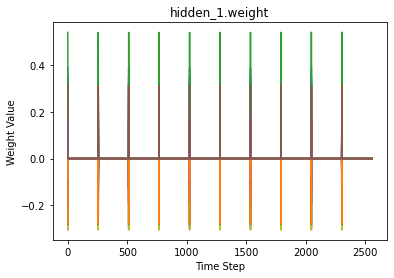

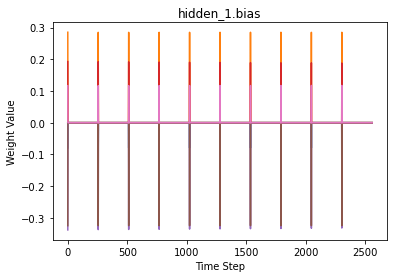

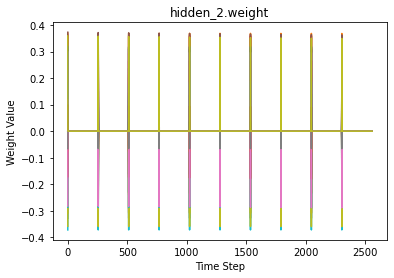

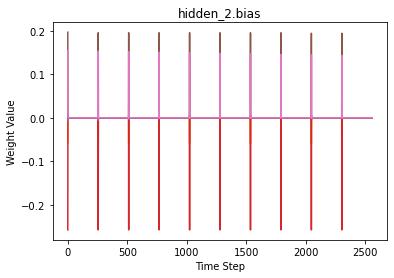

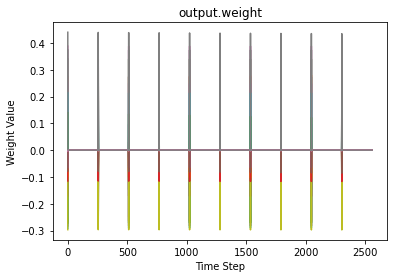

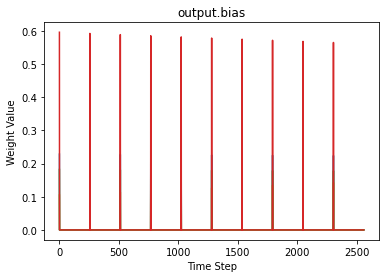

In [174]:
lab.graph(diff=0)